In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import FE_DAE as fe
from FE_DAEsolver import *
from data_generator import *
import importlib
import cv2

In [2]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [3]:
torch.cuda.set_device(1) #use GPU 1

In [4]:
import torchvision
import torchvision.datasets as datasets
#Download MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

#Load
#mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(0) #use GPU 1

In [6]:
data_load = torch.utils.data.DataLoader(mnist_trainset, shuffle = True)

In [7]:
mov_len = 3

In [8]:
images = data_load.dataset.data[0:1000].numpy()
M = rand_trans(images, 1, 3)
data_mov = torch.from_numpy(image_gen(images,M, mov_len)).float().cuda()
data_mov = data_mov/255

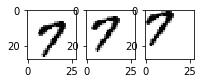

In [9]:
ix = 15
fig = plt.figure(figsize = (mov_len,5))
for i in range(mov_len):
    fig.add_subplot(1,mov_len,i+1)
    plt.imshow(data_mov[ix,i,:,:].cpu().numpy(),cmap='Greys')

In [10]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [20]:
main = fe.FE_V1()
main.summary()

['Layer 1 has 25 units per layer, depth 16, and RF size: 12 by 12',
 'Layer 2 has 9 units per layer, depth 16, and RF size: 3 by 3',
 'Layer 3 has 4 units per layer, depth 32, and RF size: 2 by 2',
 'Time step: 0.05 s']

In [21]:
main.print_parms()

{'pixel dim': 28,
 'RF 1 dim': 12,
 'layer1 depth': 16,
 'RF 2 dim': 3,
 'layer 2 depth': 16,
 'RF 3 dim': 2,
 'layer 3 depth': 32,
 'L1Hebb': 1e-06,
 'L1AntiH': 0.01,
 'L1thresh': 1e-06,
 'L2Hebb': 2e-06,
 'L3Hebb': 3e-06,
 'L1prob': 0.125,
 'L1 stride': 4,
 'L2 stride': 1,
 'L3 stride': 1,
 'time step': 0.05}

In [1462]:
x = main.x_init()
y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x

In [1463]:
trainSteps = 2000
for train in range(trainSteps):
    input_mov = data_mov[int(np.random.randint(0,data_mov.size(0),1))] #select a random movie sequence
    x = FE_movie(main,input_mov, 5, W_y = W_y, Q = Q, t = t, W_z = W_z,W_v = W_v)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
    if train % 100 == 0:
        print('Step: %s' % train)
    else:
        print('Step: %s' % train, end = '\r')

Step: 0
Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Step: 1100
Step: 1200
Step: 1300
Step: 1400
Step: 1500
Step: 1600
Step: 1700
Step: 1800
Step: 1900


In [1394]:
x_final = x
yF,W_yF,QF,tF,zF,W_zF,z_barF,vF,W_vF,v_barF = x_final


In [19]:
vF.shape

torch.Size([2, 2, 32])

In [12]:
# x_final2 = x_final
# yF2,W_yF2,QF2,tF2,zF2,W_zF2,z_barF2,vF2,W_vF2,v_barF2 = x_final2
# torch.save(x_final2,'Trial1parms')
x_final2 = torch.load('Trial1parms')
yF2,W_yF2,QF2,tF2,zF2,W_zF2,z_barF2,vF2,W_vF2,v_barF2 = x_final2


In [15]:
yF,W_yF,QF,tF,zF,W_zF,z_barF,vF,W_vF,v_barF = x_final2


In [16]:
zF[0,0,:]

tensor([1.3331e-07, 3.2774e-06, 2.1709e-05, 2.1580e-07, 3.4216e-08, 2.0393e-07,
        1.7175e-07, 8.1914e-08, 3.6334e-06, 5.7705e-07, 1.8512e-08, 1.3829e-04,
        4.6323e-05, 7.2334e-06, 2.3309e-06, 1.9362e+00])

In [23]:
input_mov = data_mov[9]

In [25]:
data_mov.shape

torch.Size([1000, 3, 28, 28])

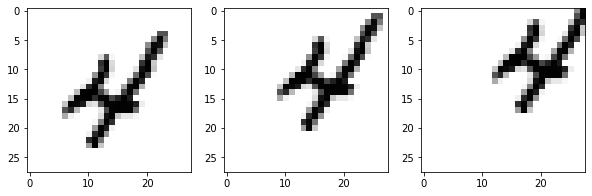

In [26]:
fig = plt.figure(figsize = (10,5))
for i in range(mov_len):
    fig.add_subplot(1,mov_len,i+1)
    plt.imshow(input_mov[i,:,:].cpu().numpy(),cmap='Greys')

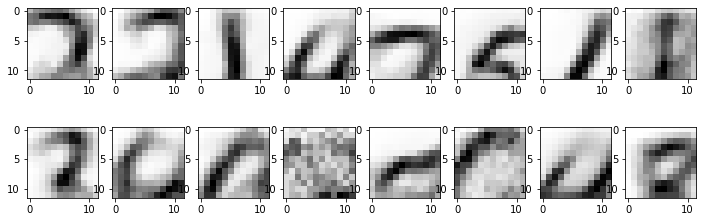

In [29]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[1,2,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')

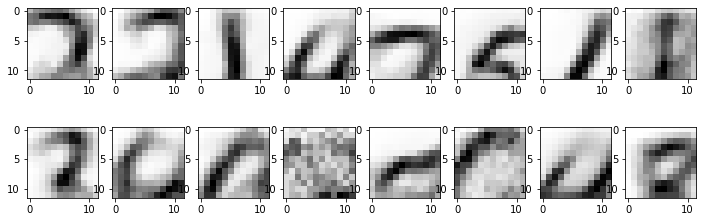

In [30]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[1,2,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')

In [38]:
def visZ(DAE, x, a,b,ix):
    '''Visualize higher layer weight matrices. For each "point" in the RF of a neuron, will visualize the lower layer's RF's.
    (a,b) are the Cartesian coordinates, while ix denotes the depth
    '''
    N,n1,d1,n2,d2,n3,d3, alpha, beta, gamma, eta, theta, p, S1, S2, S3, h = DAE.print_parms().values()
    L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
    L2_dim = int((L1_dim + S2 - n2)/S2)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
    
    fig = plt.figure(figsize = (10,10))
    WZ = W_z[a,b,ix].reshape(n2,n2,d1)
    for i in range(n2):
        for j in range(n2):
            max_ix = torch.argmax(WZ[i,j,:])
            fig.add_subplot(n2,n2,n2*i + j + 1)
            plt.imshow(W_y[(S2*a+i), (S2*b+j), ix,:].reshape(n1,n1).cpu().numpy(), cmap = 'Greys')
            
    return 

In [1448]:
testW = W_z[0,0,1].reshape(3,3,16)

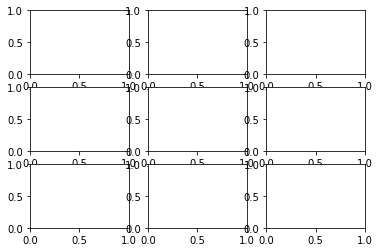

In [32]:
fig2, ax2 = plt.subplots(3,3)

In [1458]:
ax2[9]

IndexError: index 9 is out of bounds for axis 0 with size 3

In [1452]:
testW[1,1,:]

tensor([0.8763, 0.3746, 0.2031, 0.8833, 0.6072, 0.6715, 0.7738, 0.7709, 0.1945,
        0.9086, 0.2059, 0.6901, 0.1982, 0.0443, 0.2621, 0.8889])

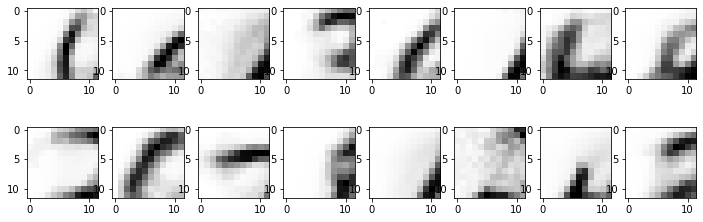

In [36]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[1,1,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')

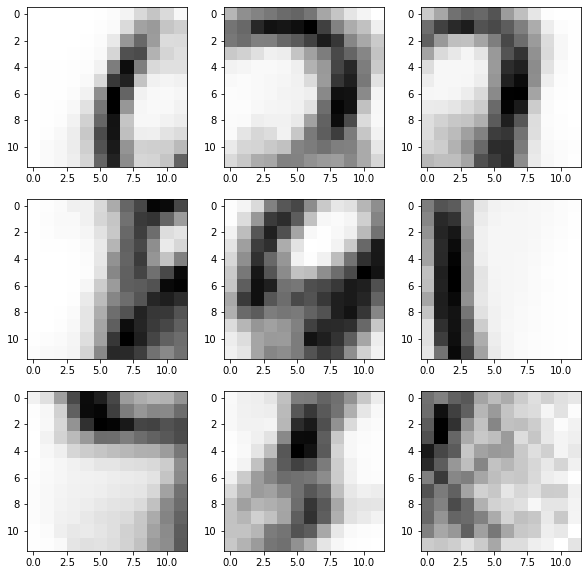

In [39]:
visZ(main, x_final2, 1,1,0)

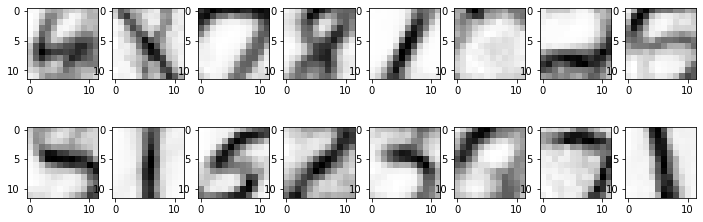

In [1340]:
fig = plt.figure(figsize = (12,4))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow((W_yF[2,2,i,:].cpu().numpy()).reshape(12,12),cmap='Greys')

In [1237]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [1162]:
main = fe.FE_V1()
main.summary()

['Layer 1 has 25 units per layer, depth 16, and RF size: 12 by 12',
 'Layer 2 has 9 units per layer, depth 16, and RF size: 3 by 3',
 'Layer 3 has 4 units per layer, depth 32, and RF size: 2 by 2',
 'Time step: 0.05 s']

In [1397]:
xtest = main.x_init()
y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = xtest
yhold = torch.zeros_like(y).repeat(100,1,1,1)
for i in range(100):
    xtest = FE_solve(main, .05, 0, xtest, mov2u(data_mov[0]), Reset = 0,W_y = W_yF, Q = QF, t = tF, W_z = W_zF,W_v = W_vF)
    y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = xtest
    yhold[i,:,:,:] = y

In [1398]:
yhold[99,3,3,:]

tensor([3.1228e-04, 3.3421e-04, 3.1772e-04, 6.4314e-01, 4.6911e-04, 3.1846e-04,
        4.0829e-04, 3.2135e-04, 3.4299e-04, 3.6137e-04, 3.3555e-04, 3.7649e-04,
        3.4240e-04, 3.1873e-04, 3.1739e-04, 3.9674e-04])

In [1399]:
z[2,2,:]

tensor([0.0069, 0.0019, 0.0006, 0.0623, 0.0138, 0.4970, 0.0074, 0.0016, 0.1900,
        0.0629, 0.0807, 0.0464, 0.0135, 0.0007, 0.0346, 0.0013])

In [948]:
importlib.reload(fe)

<module 'FE_DAE' from '/home/shazoop/form-and-motion/EE219A/FE_DAE.py'>

In [1294]:
main = fe.FE_V1()
main.summary()
xtest = main.x_init()
y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = x
xtest = FE_movie(main,data_mov[3], 1, W_y = W_yF, Q = QF, t = tF, W_z = W_zF,W_v = W_vF)
y,W_y,Q,t,z,W_z,z_bar,v,W_v,v_bar = xtest

In [1405]:
N,n1,d1,n2,d2,n3,d3, alpha, beta, gamma, eta, theta, p, S1, S2, S3, h = main.print_parms().values()
L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
L2_dim = int((L1_dim + S2 - n2)/S2)
WZ = W_z.reshape(L2_dim,L2_dim, d2, n2,n2,d1)


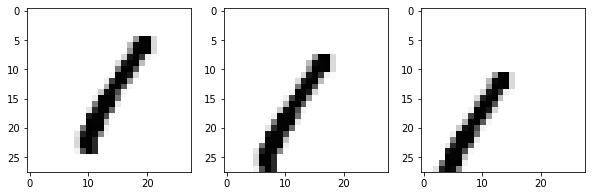

In [1295]:
fig = plt.figure(figsize = (10,5))
for i in range(mov_len):
    fig.add_subplot(1,mov_len,i+1)
    plt.imshow(data_mov[3,i,:,:].cpu().numpy(),cmap='Greys')

In [202]:
y[0,0,:]

tensor([0., 0., 0., 0., 0., 0.])

In [214]:
z

tensor([[[0.1660, 0.1657, 0.1660, 0.1659, 0.1658, 0.1658],
         [0.1741, 0.1740, 0.1740, 0.1742, 0.1743, 0.1740]],

        [[0.1635, 0.1635, 0.1634, 0.1635, 0.1634, 0.1634],
         [0.1685, 0.1688, 0.1686, 0.1686, 0.1687, 0.1687]]])

In [215]:
W_zF

tensor([[[[0.0566, 0.1467, 0.0576,  ..., 0.1109, 0.1643, 0.1376],
          [0.0568, 0.1469, 0.0578,  ..., 0.1105, 0.1642, 0.1369],
          [0.0564, 0.1466, 0.0575,  ..., 0.1108, 0.1641, 0.1376],
          [0.0565, 0.1467, 0.0574,  ..., 0.1109, 0.1644, 0.1377],
          [0.0567, 0.1471, 0.0575,  ..., 0.1107, 0.1642, 0.1374],
          [0.0565, 0.1469, 0.0577,  ..., 0.1108, 0.1645, 0.1374]],

         [[0.0829, 0.0698, 0.0802,  ..., 0.0724, 0.1058, 0.0814],
          [0.0830, 0.0695, 0.0803,  ..., 0.0723, 0.1055, 0.0814],
          [0.0827, 0.0699, 0.0805,  ..., 0.0724, 0.1056, 0.0816],
          [0.0824, 0.0696, 0.0800,  ..., 0.0726, 0.1056, 0.0814],
          [0.0826, 0.0696, 0.0802,  ..., 0.0723, 0.1058, 0.0817],
          [0.0833, 0.0698, 0.0805,  ..., 0.0722, 0.1054, 0.0815]]],


        [[[0.1733, 0.0628, 0.0854,  ..., 0.1245, 0.0968, 0.1285],
          [0.1731, 0.0627, 0.0858,  ..., 0.1246, 0.0969, 0.1279],
          [0.1732, 0.0628, 0.0856,  ..., 0.1248, 0.0970, 0.1282],
    